# Trabajo Práctico 2: Análisis con Stacking - Organización de Datos

# **Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df
from funciones_auxiliares import graficar_matriz_confusion

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo. También segmentamos el dataset en X e y (target):

In [6]:
df = traer_df()
df = preparar_dataset(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [7]:
X, y = dividir_dataset(df)
X = aplicar_one_hot_encoding(X)
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

Asignamos los clasificadores a ser utilizados para realizar el ensamble. En este caso, utilizamos los que mejor ROC-AUC score proporcionaron: KNN, SVM y Random Forest, cada uno con sus mejores hiperparámetros.

In [8]:
clf_1 = KNeighborsClassifier(n_neighbors = 40, weights = 'uniform', metric = 'cosine')
clf_2 = SVC(kernel = 'rbf', C = 0.1, degree = 2, gamma = 0.01, probability = True)
clf_3 = RandomForestClassifier(max_depth = 16, n_estimators = 500, criterion = 'entropy')

## Entrenamiento y predicción con el dataset original

Generamos el ensamble con los modelos anteriormente mencionados:

In [9]:
stacking = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], n_jobs = -1
)

Normalizamos los datos del dataset original y entrenamos el modelo:

In [10]:
X_train, X_test = normalizar_datos(X_train_original, X_test_original)
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('clf_1',
                                KNeighborsClassifier(metric='cosine',
                                                     n_neighbors=40)),
                               ('clf_2',
                                SVC(C=0.1, degree=2, gamma=0.01,
                                    probability=True)),
                               ('clf_3',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=16,
                                                       n_estimators=500))],
                   n_jobs=2)

Ahora hacemos que este prediga sobre el subset de validation:

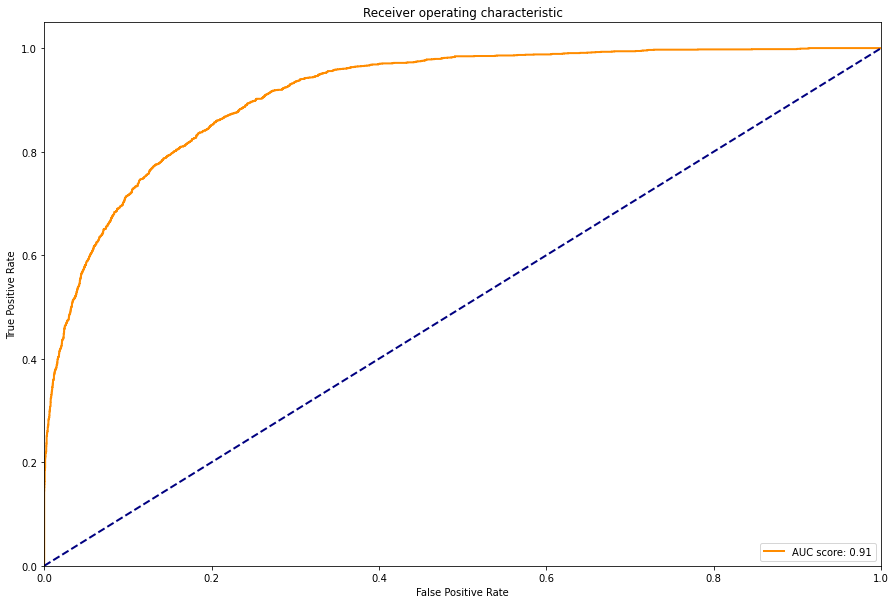

El valor de la metrica AUC-ROC para este modelo es: 0.9134206538140253


In [11]:
y_pred = stacking.predict(X_test)
y_pred_proba = stacking.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar un AUC score bastante alto, 0.91. Tiene sentido, pues estamos realizando un ensamble de los modelos que mejores resultados dieron.

Imprimimos el classification report:

In [12]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.882     0.944     0.912      6181
   Tiene Alto Valor Adquisitivo      0.774     0.603     0.678      1960

                       accuracy                          0.862      8141
                      macro avg      0.828     0.774     0.795      8141
                   weighted avg      0.856     0.862     0.856      8141



Podemos ver que los valores de precision y recall para las instancias con pocos ingresos son muy elevados. Por otra parte, las instancias con alto valor adquisitivo son predichas con una precision relativamente alta, pero un recall regular. Se podría decir que al Stacking le cuesta más clasificar estas últimas. Esto se ve más claramente en la siguiente matriz de confusión:

In [13]:
from funciones_auxiliares import graficar_matriz_confusion

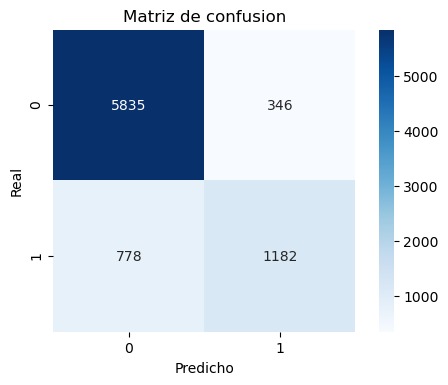

In [14]:
graficar_matriz_confusion(y_test, y_pred)

Se puede ver en la matriz que el modelo no posee ninguna tendencia muy clara a predecir una clase sobre la otra.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train_original, X_exp_test_original, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0, stratify=y)

Generamos el ensamble para el dataset expandido con los modelos anteriormente mencionados:

In [17]:
stacking_expandido = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], n_jobs = -1
)

Normalizamos los datos del dataset ampliado y entrenamos el modelo:

In [18]:
X_exp_train, X_exp_test = normalizar_datos(X_exp_train_original, X_exp_test_original)
stacking_expandido.fit(X_exp_train, y_exp_train)

StackingClassifier(estimators=[('clf_1',
                                KNeighborsClassifier(metric='cosine',
                                                     n_neighbors=40)),
                               ('clf_2',
                                SVC(C=0.1, degree=2, gamma=0.01,
                                    probability=True)),
                               ('clf_3',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=16,
                                                       n_estimators=500))],
                   n_jobs=2)

Ahora hacemos que este prediga sobre el subset de validation:

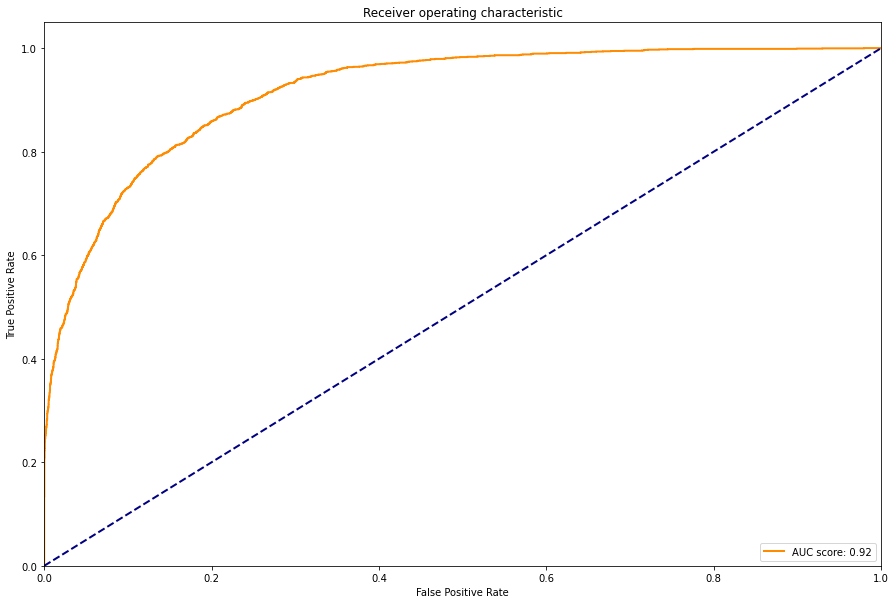

El valor de la metrica AUC-ROC para este modelo es: 0.9169782975477848


In [19]:
y_pred = stacking_expandido.predict(X_exp_test)
y_pred_proba = stacking_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar un AUC score levemente superior al del Stacking con el dataset original. A continuación, vemos el classification report:

In [20]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.883     0.946     0.914      6181
   Tiene Alto Valor Adquisitivo      0.780     0.606     0.682      1960

                       accuracy                          0.864      8141
                      macro avg      0.832     0.776     0.798      8141
                   weighted avg      0.858     0.864     0.858      8141



Se ve una muy leve mejora en el recall para las instancias que poseen alto valor adquisitivo. Es decir, estas instancias fueron mejor clasificadas según el target. Lo mismo ocurre con la precision. Esto se ve en la matriz de confusión:

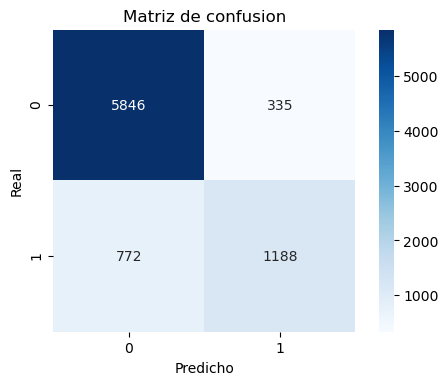

In [21]:
graficar_matriz_confusion(y_test, y_pred)

No se observa ninguna tendencia a predecir una clase sobre la otra.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con Stacking con el dataset expandido sobre el dataset de predicciones nuevo, y la escribimos al archivo 'Stacking.csv'

In [22]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [23]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)
X_exp_train_normalizado, df_predicciones = normalizar_datos(X_exp_train_original, df_predicciones)

In [24]:
predicciones = stacking_expandido.predict(df_predicciones)
escribir_predicciones(ids, predicciones, "Stacking")